# Model Hyperparameter tuning and analysis portal

We will use this notebook to:
- visualize dataset.
- find the correct model by grid search with 5-fold CV.
- save best performing model into pickle file that is ready to be deployed as API.
- visualize errors on customizable error metrics.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Visualize dataset
Split development set and test set.  
Test set: 2020-01-01 and onward.  
Dev set: any data before 2020-01-01.

## 2. Find best model
### 2.1 RandomForest with CV

In [14]:
from sklearn.metrics import mean_squared_error

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
        
    n_train =features.shape[0]-n_test
    
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]

    #train regressor
    regressor.fit(X_train, y_train)
    
    print("Train-set water level R^2: {:.2f}".format(regressor.score(X_train, y_train)))
    print("Test-set water level R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    print("Train-set water level RMSE: {:.2f}".format(mean_squared_error(y_train, 
                                                             y_pred_train, 
                                                            squared=False)))
    print("Test-set water level RMSE: {:.2f}".format(mean_squared_error(y_test, 
                                                            y_pred,
                                                           squared=False)))
    #prepare plotting
    plt.figure(figsize=(10, 3))
    
    # get xticks in days for range present in feature vector
    xticks = pd.date_range(start=ram.index[features.index[0]], end=ram.index.max(),
                       freq='2Y')

    plt.xticks(range(0, len(ram.values), 8), xticks.strftime("%Y"), rotation=90,
               ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("water level m")
    plt.grid()

In [15]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(X_year_month):
    print("train size:", train_index.shape, "test size:", test_index.shape)

train size: (60,) test size: (59,)
train size: (119,) test size: (59,)
train size: (178,) test size: (59,)


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

regressor = RandomForestRegressor(n_estimators=100, random_state=0)

scores = cross_val_score(regressor, X_year_month, y, cv=tscv)

print(scores)
print(f"mean= {scores.mean():.3f}")

[-2.89178724 -1.6942698  -4.38902262]
mean= -2.992


Train-set log-price R^2: 1.00
Test-set log-price R^2: -5.10
Train-set log-price RMSE: 0.10
Test-set log-price RMSE: 3.63


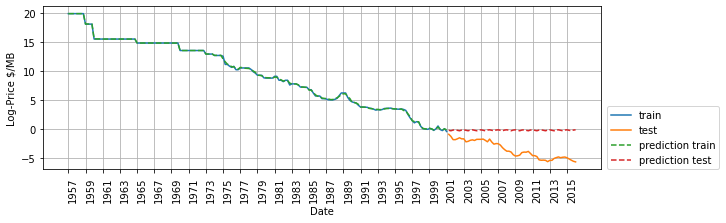

In [17]:
eval_on_features(X_year_month, y, regressor)

### 2.2 Multiple lag features

We can use this shifting technique to engineer multiple feature columns, each with a different lag.

One time step is 3 months. We include lags of 1-4 3 months chunks. This would mean that we need one year worth of data to do predictions.